# Анализ данных кредитного скоринга
### by Safronenkov Roman

#### 1. Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:   a)  о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки  b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

#### 2. Пол (SEX): Проверьте гипотезу о том,  что гендерный состав  группы людей вернувших и не вернувших кредит отличается.  Хорошо, если вы предоставите несколько различных решений  этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

#### 3. Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.  Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы  разность между наблюдаемым и ожидаемым количеством человек.  Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?  Наличие какого образования является наилучшим индикатором того, что человек  отдаст долг ? наоборт, не отдаст долг ?

#### 4. Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

#### 5. Возраст (AGE): Относительно двух групп людей  вернувших и не вернувших кредит  проверьте следующие гипотезы:   a)  о равенстве медианных значений возрастов людей   b) о равенстве распределений  с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

In [1]:
import itertools

import pandas as pd
import numpy as np
from scipy import stats as sts
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.multitest import multipletests

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

%matplotlib inline

plt.rcParams['figure.figsize'] = (10., 8.)

In [2]:
ALPHA = 0.05  # зафиксируем уровень значимости

#### LIMIT_BAL:  размер кредитного лимита (в том числе и на семью клиента)

#### SEX: пол клиента (1 = мужской, 2 = женский )

#### EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).

#### MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных). 

#### AGE: возраст в годах

#### PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)

#### BILL_AMT1 - BILL_AMT6:  задолженность,  BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь 

#### PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре 

#### default - индикатор невозврата денежных средств

In [3]:
data = pd.read_csv('credit_card_default_analysis.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
default_true_subset = data[data['default'] == 1]
default_false_subset = data[data['default'] == 0]

In [5]:
default_true_subset.shape, default_false_subset.shape

((6636, 25), (23364, 25))

## Задание №1

### Построим распределения для размера кредитного лимита для людей, кто вернул кредит и для тех кто нет, вертикальными чертами отобразим медианы этих рпспределений

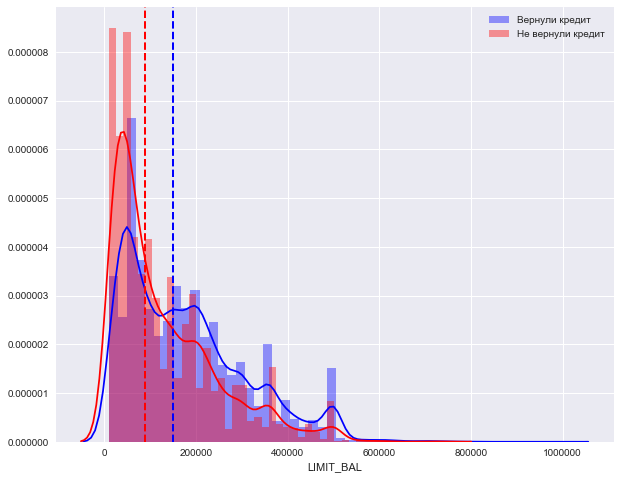

In [6]:
limit_bal_1 = default_true_subset['LIMIT_BAL'].values
limit_bal_0 = default_false_subset['LIMIT_BAL'].values

fig, ax = plt.subplots()


sns.distplot(limit_bal_0, ax=ax, label='Вернули кредит', color='blue')
sns.distplot(limit_bal_1, ax=ax, label='Не вернули кредит', color='red')

ax.axvline(np.median(limit_bal_0), color='blue', lw=2, ls='dashed')
ax.axvline(np.median(limit_bal_1), color='red', lw=2, ls='dashed')

ax.set_xlabel('LIMIT_BAL')
ax.legend();

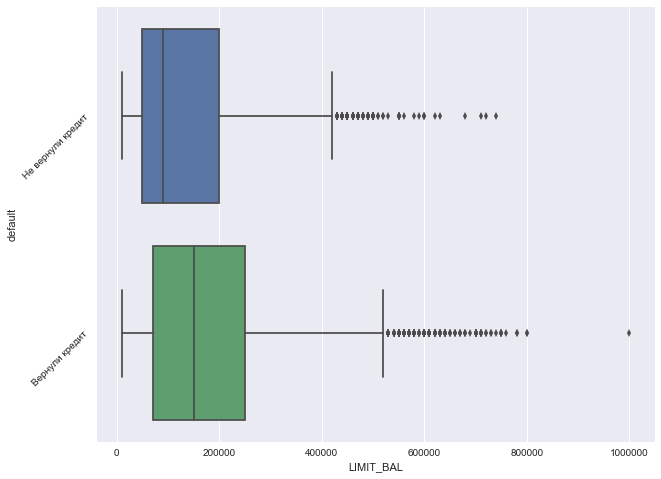

In [7]:
fig, ax = plt.subplots()

sns.boxplot(x='LIMIT_BAL', y='default', data=data, ax=ax, orient='h', order=[1, 0])
ax.set_yticklabels(['Не вернули кредит', 'Вернули кредит'])
plt.yticks(rotation=45);

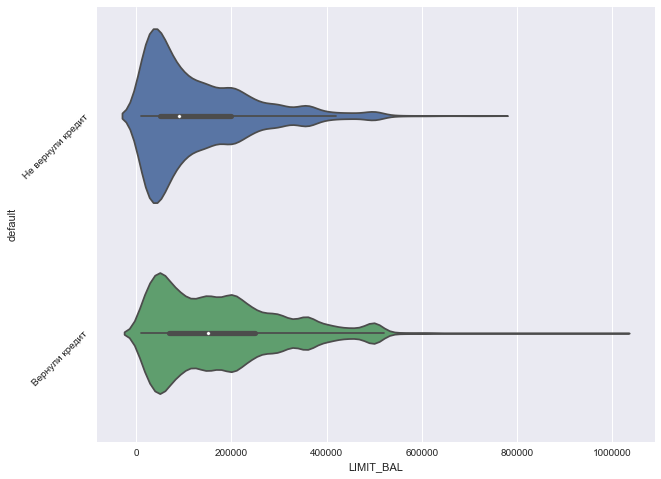

In [8]:
fig, ax = plt.subplots()

sns.violinplot(x='LIMIT_BAL', y='default', data=data, ax=ax, orient='h', order=[1, 0])
ax.set_yticklabels(['Не вернули кредит', 'Вернули кредит'])
plt.yticks(rotation=45);

### Смотря на графики, можно зрительно сделать вывод, что медианы отличаются. Судя по всему чаще не отдают небольшие кредиты, так как медиана размера кредитного лимита меньше для невернувших кредит. Проверим, значимо ли это отличие, построив доверительный интервал для разности медиан с помощью бутстрепа

In [9]:
def get_bootstrap_samples(x, B_sample=1):
    N = x.size 
    sample = np.random.choice(x, size=(N, B_sample), replace=True)
    
    if B_sample == 1:
        sample = sample.T[0]
    return sample

def efron_ci(x, alpha=ALPHA):
    left = np.quantile(x, alpha/2)
    right = np.quantile(x, 1-alpha/2)
    return left, right

In [10]:
%%time
bootstrap0 = get_bootstrap_samples(limit_bal_0, 10**4)
bootstrap1 = get_bootstrap_samples(limit_bal_1, 10**4)

medians0 = np.median(bootstrap0, axis=0)
medians1 = np.median(bootstrap1, axis=0)

diff = medians0 - medians1

del bootstrap0, bootstrap1, medians0, medians1

Wall time: 14.8 s


In [11]:
left, right = efron_ci(diff)
print(f'Доверительный интервал для разности медиан: [{left}, {right}]')

Доверительный интервал для разности медиан: [60000.0, 70000.0]


In [12]:
print(f'Точечная оценка для разности медиан: {np.median(limit_bal_0) - np.median(limit_bal_1)}')

Точечная оценка для разности медиан: 60000.0


### Доверительный интервал не содержит нуля, значит разница медиан статистически значима, также можно сделать вывод, что разница практически значима (60000 довольно много в сравнении с медианами обеих групп)

## Задание №2

In [13]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

### Востользуемся перестановочным тестом для проверки гипотезы о равенстве распределений размера кредитного лимита.
### Уровень значимости: 0.05

In [14]:
%%time
print(f'Достигаемый уровень значимости: {permutation_test(limit_bal_0, limit_bal_1, max_permutations=10000)}')

Достигаемый уровень значимости: 0.0001
Wall time: 34.2 s


### Нулевая гипотеза о равенстве распределений отвергается на уровне значимости 0.05 в пользу альтернативы

In [15]:
#  для удобства сделаем не 2\1 а 1\0

sex1 = default_true_subset['SEX'].map({2:1, 1:0}).values
sex0 = default_false_subset['SEX'].map({2:1, 1:0}).values

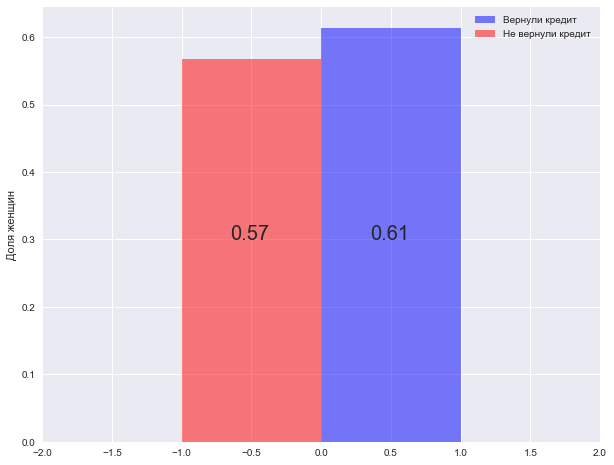

In [16]:
fig, ax = plt.subplots()

ax.bar(x=[0.5], height=[sex0.mean()], width=[1], alpha=0.5, label='Вернули кредит', color='blue')
ax.bar(x=[-0.5], height=[sex1.mean()], width=[1], alpha=0.5, label='Не вернули кредит', color='red')
ax.set_xlim([-2, 2])
ax.set_ylabel('Доля женщин')
ax.text(0.35, 0.3, f'{sex0.mean():.2f}', fontsize=20)
ax.text(-0.65, 0.3, f'{sex1.mean():.2f}', fontsize=20)

ax.legend();

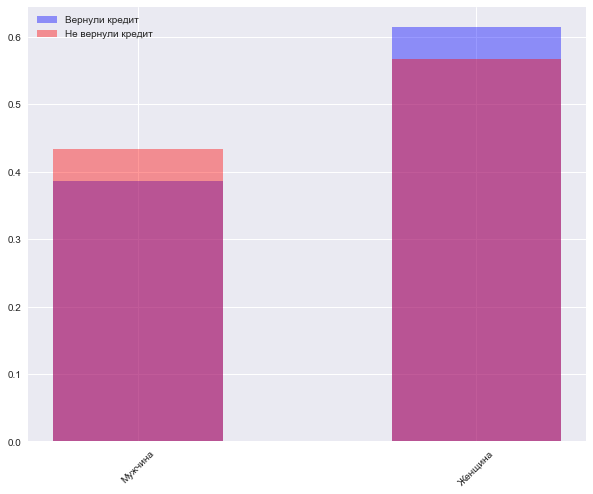

In [17]:
sex_bin0 = np.bincount(sex0, minlength=2)
sex_bin1 = np.bincount(sex1, minlength=2)

normed_sex_bin0 = sex_bin0 / np.sum(sex_bin0)
normed_sex_bin1 = sex_bin1 / np.sum(sex_bin1)

fig, ax = plt.subplots()

ax.bar(x=list(range(2)),
       height=normed_sex_bin0,
       width=0.5,
       label='Вернули кредит',
       color='blue', 
       alpha=0.4)
ax.bar(x=list(range(2)),
       height=normed_sex_bin1,
       width=0.5,
       label='Не вернули кредит', 
       color='red',
       alpha=0.4)
plt.xticks([0, 1], rotation=45)
ax.set_xticklabels(['Мужчина', 'Женщина'])
ax.legend();

### Из графиков выше видно, что мужчины чаще невозвращают кредит, чем женщины, то есть доля женщин, среди людей вернувших кредит выше, проверим, значимо ли это отличие

### Построим бутстреп доверительный интервал для разности долей

In [18]:
%%time
bootstrap0 = get_bootstrap_samples(sex0, 10**5)
bootstrap1 = get_bootstrap_samples(sex1, 10**5)

means0 = np.mean(bootstrap0, axis=0)
means1 = np.mean(bootstrap1, axis=0)

diff = means0 - means1

del bootstrap0, bootstrap1, means0, means1

Wall time: 42.2 s


In [19]:
left, right = efron_ci(diff)
print(f'{100*(1-ALPHA):.0f}% доверительный интервал для доли женщин для разницы'+ \
      f'вернувших и не вернувших кредит c помощью бутстрепа:\n'+ \
      f'{left:.4f} <= {(np.mean(sex0) - np.mean(sex1)):.4f} <= {right:.4f}')

95% доверительный интервал для доли женщин для разницывернувших и не вернувших кредит c помощью бутстрепа:
0.0336 <= 0.0471 <= 0.0605


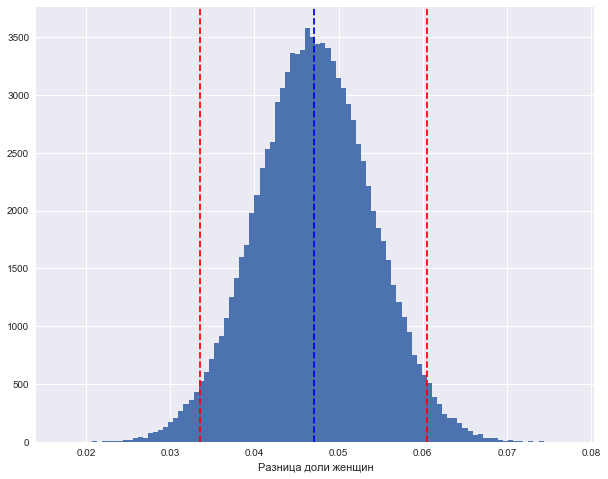

In [20]:
# визуализация ситуации выше

plt.hist(diff, bins=100);
plt.axvline(left, color='r', ls='dashed')
plt.axvline(np.mean(sex0) - np.mean(sex1), color='b', ls='dashed')
plt.axvline(right, color='r', ls='dashed')
plt.xlabel('Разница доли женщин');

### Основываясь на доверительном интервале, полученном с помощью бутстрепа, можно отвергнуть гипотезу о равенстве долей женщин на уровне значимости 0.05

### Применим асимптотический (z-test) тест на равенство долей женщин против двухсторонней альтернативы на уровне значимости 0.05

In [21]:
def proportion_ztest(sample1, sample2, aplha=ALPHA, alternative='two-sided'):
    assert alternative in ['two-sided', 'less', 'larger'], 'Alternative should be "two-sided", "less" or "larger"'
    n1,n2 = sample1.size, sample2.size  # размеры выборок
    m1,m2 = sample1.sum(), sample2.sum()  # число успехов

    p1, p2 = sample1.mean(), sample2.mean()  # точеные оценки долей 
    diff = p1 - p2  # разность долей

    P = (m1 + m2)/(n1 + n2)          
    diff_std = np.sqrt(P*(1 - P)*(1/n1 + 1/n2))  # стандартное отклонение разности

    z_obs = diff/diff_std  # наблюдаемое значение статистики
    
    if alternative == 'two-sided':
        pvalue = 2 * (1 - sts.norm.cdf(abs(z_obs)))  # двухсторонняя альтернатива
    elif alternative == 'larger':
        pvalue = 1 - sts.norm.cdf(abs(z_obs))
    elif alternative == 'less':
        pvalue = sts.norm.cdf(abs(z_obs))
        
    return z_obs, pvalue

In [22]:
pvalue = proportion_ztest(sex0, sex1, alternative='two-sided')[1]

print(f'Наблюдаемый уровень значимости {pvalue} меньше {ALPHA} => Нулевая гипотеза отвергается')

Наблюдаемый уровень значимости 4.472866521609831e-12 меньше 0.05 => Нулевая гипотеза отвергается


In [23]:
def proportions_confint_diff_ind(sample1, sample2, alpha=ALPHA):    
    z = sts.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [24]:
proportions_confint_diff_ind(sex0, sex1)

(0.03363493274962867, 0.060548077974896725)

### И гипотеза о равенстве долей (асимпотическая) и разные доверительные интервалы для разности долей говорят о статистически значимом отличии долей женщин в группах

#### P.S. Видно что доверительный интервал, построенный с помощью бутстрепа очень похож на асимптотический

## Задание №3

### Посчитаем количество людей с каждым образованием в разрезе вернувших и невернувших кредит, для этого воспользуемся np.bincount и отнормируем каждое значение на сумму всех людей в выборке.
### Отобразим различие на графике

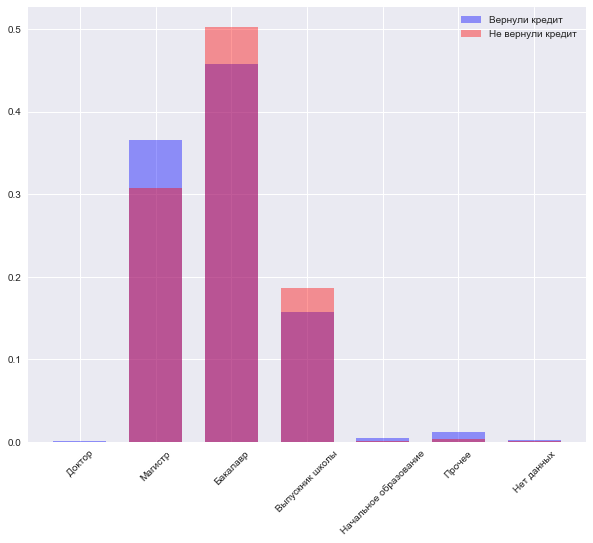

In [25]:
education_names = ['Доктор', 'Магистр', 'Бакалавр', 'Выпускник школы', 'Начальное образование', 'Прочее', 'Нет данных']

education0 = default_false_subset.EDUCATION.values
education1 = default_true_subset.EDUCATION.values

ed_bin0 = np.bincount(education0, minlength=len(education_names))
ed_bin1 = np.bincount(education1, minlength=len(education_names))

normed_ed_bin0 = ed_bin0 / np.sum(ed_bin0)
normed_ed_bin1 = ed_bin1 / np.sum(ed_bin1)

fig, ax = plt.subplots()

ax.bar(x=list(range(len(education_names))),
       height=normed_ed_bin0,
       width=0.7,
       label='Вернули кредит',
       color='blue', 
       alpha=0.4)
ax.bar(x=list(range(len(education_names))),
       height=normed_ed_bin1,
       width=0.7,
       label='Не вернули кредит', 
       color='red',
       alpha=0.4)
plt.xticks(list(range(len(education_names))), rotation=45)
ax.set_xticklabels(education_names)
ax.legend();

### Из графика выше видно, что доля магистров выше среди людей вернувших кредит, а также можно заметить, что доктора возвращали кредит всегда, исходя из данных.
### В то время как доля бакалавров и выпускников школы выше среди невернувших кредит

In [26]:
# запишем отнормированные значения в матрицу вида [вернули\не вернули кредит, образование]
# так как значения уже нормированы получим матрицу частот людей с разным образованием в двух группах
education_matrix = np.vstack((normed_ed_bin0, normed_ed_bin1))
education_matrix

array([[0.00059921, 0.36590481, 0.45796953, 0.15750728, 0.0049649 ,
        0.01121383, 0.00184044],
       [0.        , 0.30681133, 0.50180832, 0.18640747, 0.00105485,
        0.00271248, 0.00120555]])

### Проверим гипотезу о независимости этих частот на уровне значимости 0.05 против альтернативы, что все-таки связь есть

In [27]:
pvalue = sts.chi2_contingency(education_matrix)[1]
print(f'P-value гипотезы о независимости частот {pvalue} меньше уровня значимости {ALPHA}'\
      +'=> нулевая гипотеза о независимости частот не отвергается')

P-value гипотезы о независимости частот 0.999999877646858 меньше уровня значимости 0.05=> нулевая гипотеза о независимости частот не отвергается


### Проверим значимо ли отличие каждого вида образования на возврат/невозврат кредита
#### Для этого воспользуемся z-тестом на равенство долей для каждого образования по отдельности, а затем сделаем коррекцию на множественное тестирование

In [28]:
education = {i: education_names[i] for i in range(7)}
pvals = []

for i in range(7):
    sample1 = (education0 == i).astype(int)
    sample2 = (education1 == i).astype(int)
    pvalue = proportion_ztest(sample1, sample2)[1]
    pvals.append(pvalue)
    
    print(f'{education[i]}: {pvalue}')
    
pvals = np.array(pvals)

Доктор: 0.04609196198446375
Магистр: 0.0
Бакалавр: 2.6785040851962094e-10
Выпускник школы: 1.99542846690548e-08
Начальное образование: 1.087771186969455e-05
Прочее: 2.0730572813931758e-10
Нет данных: 0.26789290279613054


In [29]:
pvals < 0.05  # видно, что без коррекции не отвергается гипотеза о равенстве долей только для "Нет данных"

array([ True,  True,  True,  True,  True,  True, False])

In [30]:
pvals_corrected = multipletests(pvals, method='holm')[1]

In [31]:
pvals_corrected < 0.05
# после коррекции методом холма гипотеза о равенстве долей отвергается и для "Доктор", остальные значимо отличаются

array([False,  True,  True,  True,  True,  True, False])

### Теперь с помощью коэффициента корреляции Мэтьюса проверим как влияет то или иное образование на возврат кредита
#### Отрицательное значение коэффициента будет означать, что человек с этим образованием скорее вернет кредит, чем нет, так же проверим значимость корреляции
#### На уровне значимости 0.05 проверяем значимость коэффициента корреляции Мэтьюса, нулевая гипотеза: коэффициент равен нулю, против альтернативы: коэффициент нулю не равен

In [32]:
def mattews_coeff(conf_matrix):
    a = conf_matrix[0][0]
    b = conf_matrix[0][1]
    c = conf_matrix[1][0]
    d = conf_matrix[1][1]
    
    numerator = a*d - b*c
    denominator = np.sqrt((a + b)*(a + c)*(b + d)*(c + d))
    
    return numerator / denominator

def mattews_coeff_test(coef, n):
    statistic = n * coef**2
    
    pvalue = (1 - sts.chi2(df=1).cdf(statistic))
    return statistic, pvalue

In [33]:
pvals = []

for i in range(7):
    # выделим каждое образование по отдельности и сравним со значениями возврат\невозврат кредита
    matrix = confusion_matrix((data['EDUCATION'] == i).astype(int),  data['default'])
    
    corr = mattews_coeff(matrix)
    statistic, pvalue = mattews_coeff_test(corr, np.sum(matrix))
    pvals.append(pvalue)
    print(education[i],'correlation = ', corr,'\npvalue =', pvalue)
pvals = np.array(pvals)

Доктор correlation =  -0.011515540826935882 
pvalue = 0.046091961984463636
Магистр correlation =  -0.05132774863874091 
pvalue = 0.0
Бакалавр correlation =  0.0364673392507712 
pvalue = 2.678505195419234e-10
Выпускник школы correlation =  0.03240318989212772 
pvalue = 1.9954284558032498e-08
Начальное образование correlation =  -0.025397335416931417 
pvalue = 1.087771186969455e-05
Прочее correlation =  -0.03669539480286645 
pvalue = 2.0730572813931758e-10
Нет данных correlation =  -0.006396625413555772 
pvalue = 0.26789290279613087


In [34]:
pvals < 0.05

array([ True,  True,  True,  True,  True,  True, False])

In [35]:
pvals_corrected = multipletests(pvals, method='holm')[1]

In [36]:
pvals_corrected < 0.05

array([False,  True,  True,  True,  True,  True, False])

In [37]:
np.array(education_names)[pvals_corrected < 0.05]

array(['Магистр', 'Бакалавр', 'Выпускник школы', 'Начальное образование',
       'Прочее'], dtype='<U21')

### Сделав поправку на множественное тестирование методом Холма, получаем, что корреляция значима только для образований: Магистр, Бакалавр, Выпускник школы, Начальное образование, Прочее
#### Магистр, начальное образование и прочее: корреляция отрицательная, значит они скорее отдадут кредит, чем нет
#### Бакалавр, выпускник школы: корреляция положительная, значит они скорее не отдадут кредит

#### P.S. Заметим, что результаты согласуются с результатами, полученными для теста на равенство долей

## Задание №4

### Воспользуемся способом, описанным выше

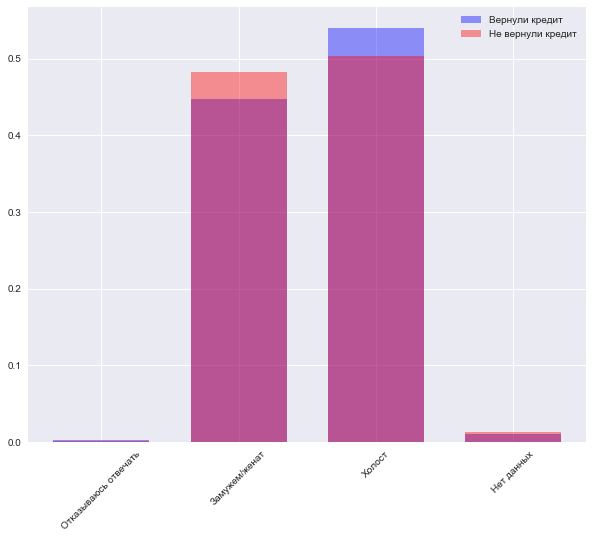

In [38]:
marriage_names = ['Отказываюсь отвечать', 'Замужем/женат', 'Холост', 'Нет данных']

marriage0 = default_false_subset.MARRIAGE.values
marriage1 = default_true_subset.MARRIAGE.values

ma_bin0 = np.bincount(marriage0, minlength=len(marriage_names))
ma_bin1 = np.bincount(marriage1, minlength=len(marriage_names))

normed_ma_bin0 = ma_bin0 / np.sum(ma_bin0)
normed_ma_bin1 = ma_bin1 / np.sum(ma_bin1)

fig, ax = plt.subplots()

ax.bar(x=list(range(len(marriage_names))),
       height=normed_ma_bin0,
       width=0.7,
       label='Вернули кредит',
       color='blue', 
       alpha=0.4)
ax.bar(x=list(range(len(marriage_names))),
       height=normed_ma_bin1,
       width=0.7,
       label='Не вернули кредит', 
       color='red',
       alpha=0.4)
plt.xticks(list(range(len(marriage_names))), rotation=45)
ax.set_xticklabels(marriage_names)
ax.legend();

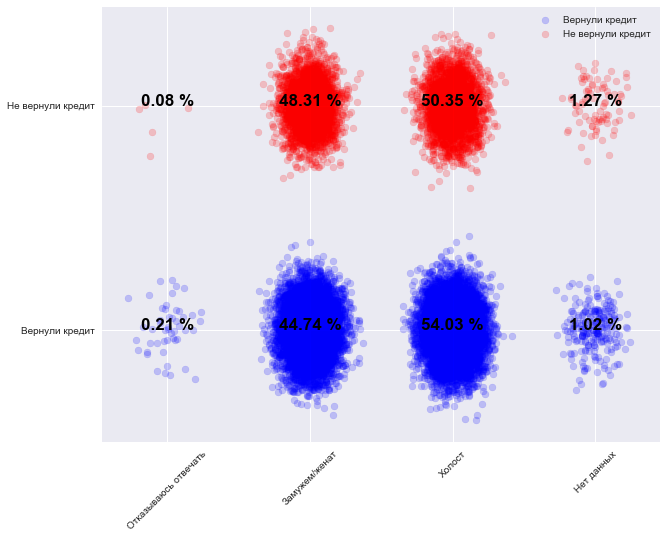

In [56]:
fig, ax = plt.subplots()
zeros = data['default'] == 0
ones = data['default'] == 1

ax.scatter(
    data['MARRIAGE'][zeros]+np.random.normal(size=sum(zeros), scale=0.1),
    data['default'][zeros]+np.random.normal(size=sum(zeros), scale=0.1),
    alpha=0.2,
    color='blue',
    label='Вернули кредит'
)

ax.scatter(
    data['MARRIAGE'][ones]+np.random.normal(size=sum(ones), scale=0.1),
    data['default'][ones]+np.random.normal(size=sum(ones), scale=0.1),
    alpha=0.2,
    color='red',
    label='Не вернули кредит'
)

plt.xticks(list(range(len(marriage_names))), rotation=45)
plt.yticks(list(range(2)), rotation=0)
ax.set_xticklabels(marriage_names)
ax.set_yticklabels(['Вернули кредит', 'Не вернули кредит'])

ma_bin_matrix = np.vstack((ma_bin0, ma_bin1))
for y in [0, 1]:
    for x in [0, 1, 2, 3]:
        string = str(np.round(ma_bin_matrix[y, x] / ma_bin_matrix.sum(axis=1)[y] * 100, 2)) + ' %'
        plt.text(
            x,
            y,
            string,
            fontsize=17,
            color='black',
            fontweight='bold',
            ha='center'
        )
ax.legend();

In [40]:
pvals = []

for i in range(4):
    matrix = confusion_matrix((data['MARRIAGE'] == i).astype(int),  data['default'])
    
    corr = mattews_coeff(matrix)
    statistic, pvalue = mattews_coeff_test(corr, np.sum(matrix))
    pvals.append(pvalue)
    print(marriage_names[i],'correlation = ', corr,'\npvalue =', pvalue)
pvals = np.array(pvals)

Отказываюсь отвечать correlation =  -0.013157940567972553 
pvalue = 0.022665748122541518
Замужем/женат correlation =  0.029774610412467022 
pvalue = 2.5078539633849317e-07
Холост correlation =  -0.03061938474838281 
pvalue = 1.1364492125132131e-07
Нет данных correlation =  0.009768097322225468 
pvalue = 0.0906680769319923


In [41]:
pvals_corrected = multipletests(pvals, method='holm')[1]

In [42]:
pvals_corrected < 0.05

array([ True,  True,  True, False])

### Тем же способом, что и для образования, получили, что значимо на то, отдасть ли человек кредит или нет влияют: Отказываюсь отвечать, Замужем/женат, Холост.
#### Причем те, кто отказываются отвечать и холостые судя по всему отдают кредит охотнее, чем женатые

## Задание №5

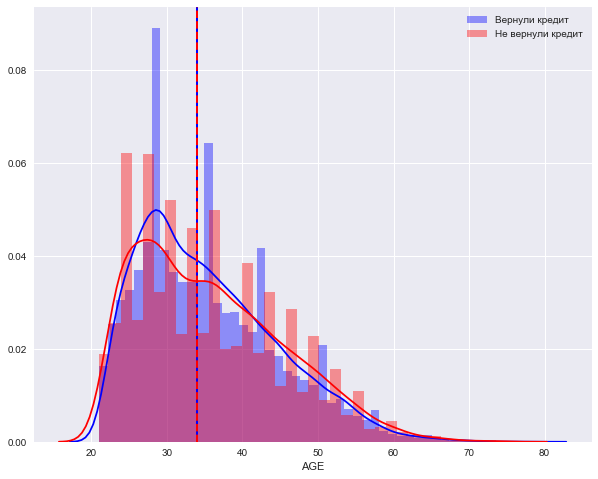

In [67]:
age0 = default_false_subset['AGE'].values
age1 = default_true_subset['AGE'].values

fig, ax = plt.subplots()


sns.distplot(age0, ax=ax, label='Вернули кредит', color='blue')
sns.distplot(age1, ax=ax, label='Не вернули кредит', color='red')

ax.axvline(np.median(age0), color='blue', lw=2)
ax.axvline(np.median(age1), color='red', lw=2, ls='dashed')

ax.set_xlabel('AGE')
ax.legend();

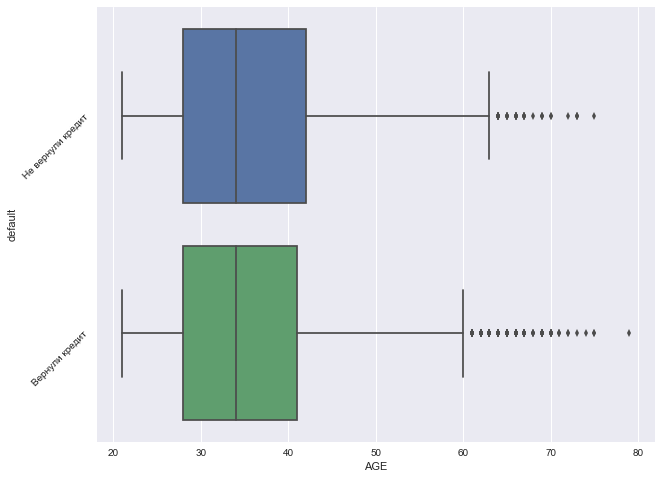

In [68]:
fig, ax = plt.subplots()

sns.boxplot(x='AGE', y='default', data=data, ax=ax, orient='h', order=[1, 0])
ax.set_yticklabels(['Не вернули кредит', 'Вернули кредит'])
plt.yticks(rotation=45);

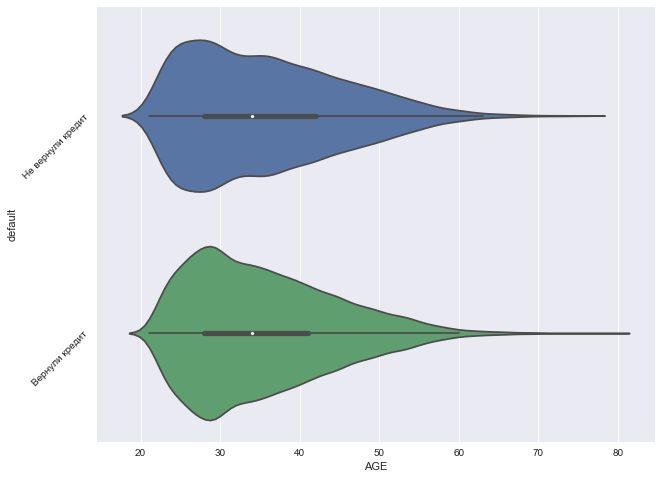

In [69]:
fig, ax = plt.subplots()

sns.violinplot(x='AGE', y='default', data=data, ax=ax, orient='h', order=[1, 0])
ax.set_yticklabels(['Не вернули кредит', 'Вернули кредит'])
plt.yticks(rotation=45);

### Из графиков выше, можно сказать, что распределения возраста для двух групп: вернувших и не вернувших кредит очень близки, медианы и вовсе совпадают

In [70]:
%%time
bootstrap0 = get_bootstrap_samples(age0, 10**4)
bootstrap1 = get_bootstrap_samples(age1, 10**4)

medians0 = np.median(bootstrap0, axis=0)
medians1 = np.median(bootstrap1, axis=0)

diff = medians0 - medians1

del bootstrap0, bootstrap1, medians0, medians1

Wall time: 18.3 s


In [71]:
left, right = efron_ci(diff)
print(f'Доверительный интервал для разности медиан: [{left}, {right}]')

Доверительный интервал для разности медиан: [-1.0, 0.0]


In [73]:
print(f'Точечная оценка для разности медиан: {np.median(age0) - np.median(age1)}')

Точечная оценка для разности медиан: 0.0


### Ноль попадает в интервал, а значит мы не можем отвергнуть гипотезу о равенстве медиан, пользуясь интервальной оценкой с помощью бутстрепа

### Проверим с помощью перестановочного критерия гипотезу о равенстве распределений на уровне значимости 0.05

In [90]:
%%time
print(f'Достигаемый уровень значимости: {permutation_test(age0, age1, max_permutations=10000)}')

Достигаемый уровень значимости: 0.0177
Wall time: 57.2 s


### Гипотеза о равенстве распределений отвергается на уровне значимости 0.05 в пользу альтернативы

### Получается медианы распределений равны, но сами распределения нет